In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


import sys 
sys.path.append('/home/mahakaran/NK-paper-12-5-24-version/nk-ml-paper2-2024/pscapes')
sys.path.append('/home/mahakaran/NK-paper-12-5-24-version/nk-ml-paper2-2024/nk-ml-2024')


import numpy as np
import itertools
from sklearn.utils import gen_batches

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

from torch.utils.data import Subset

from sklearn.model_selection import train_test_split
from pscapes.landscape_models import make_NK
from pscapes.landscape_class import Protein_Landscape
from pscapes.utils import dict_to_np_array

from src.architectures.testlstm import AminoAcidLSTM
#from src.architectures.ml_utils import train_model

In [2]:
AA_ALPHABET = 'ACDEFG'
SEQ_LENGTH  = 6
K_VALS   = list(range(SEQ_LENGTH))

In [3]:
NK_LANDSCAPES = [make_NK(SEQ_LENGTH, k, AA_ALPHABET, np.random.uniform) for k in K_VALS]

In [4]:
LANDSCAPES = [Protein_Landscape(data=dict_to_np_array(i), amino_acids=AA_ALPHABET) for i in NK_LANDSCAPES]

In [5]:
%%capture

#fit one hot
[i.fit_OHE() for i in LANDSCAPES]

In [6]:
#MLP_params
input_size = SEQ_LENGTH * len(AA_ALPHABET)  # Total input size after flattening
input_size

36

In [7]:
AminoAcidLSTM?

In [8]:
#instantiate models
models     = [AminoAcidLSTM(len(AA_ALPHABET)) for i in LANDSCAPES]
loss_fns   = [nn.MSELoss() for i in models]
optimizers = [optim.Adam(i.parameters(), lr=0.001) for i in models]

In [9]:
batch_size1 = 32
LANDSCAPES[0].fitnesses.shape

(46656,)

In [36]:
LANDSCAPES_OHE = [np.array(i.one_hot_encodings) for i in LANDSCAPES]

X_OHE = LANDSCAPES_OHE
Y_OHE = [i.fitnesses.reshape(-1,1).astype(float) for i in LANDSCAPES]
XY_OHE = [list(zip(torch.from_numpy(X_OHE[i]).to(torch.float32), torch.from_numpy(Y_OHE[i]).to(torch.float32))) for i in range(len(X_OHE))]
XY_OHE_TRAIN_TEST_SPLIT = [train_test_split(i, test_size=round(len(i)*0.2)) for i in XY_OHE]

XY_TRAIN = [i[0] for i in XY_OHE_TRAIN_TEST_SPLIT]
XY_TEST  = [i[1] for i in XY_OHE_TRAIN_TEST_SPLIT]

XY_TRAIN_VAL_SPLIT = [train_test_split(i, test_size=round(len(i)*0.2)) for i in XY_TRAIN]

XY_TRAINING = [i[0] for i in XY_TRAIN_VAL_SPLIT]
XY_VAL      = [i[1] for i in XY_TRAIN_VAL_SPLIT]
                           
                                    





In [37]:
print(len(XY_TRAINING[0]))
print(len(XY_VAL[0]))
print(len(XY_TEST[0]))

29860
7465
9331


In [38]:
len(XY_VAL[0])

7465

In [39]:
TRAIN_DATALOADER = [DataLoader(i, batch_size=batch_size1) for i in XY_TRAINING]
VAL_DATALOADER   = [DataLoader(i, batch_size=batch_size1) for i in XY_VAL]

In [40]:
X_TEST = []
Y_TEST = []

for ind, i in enumerate(XY_OHE_TRAIN_TEST_SPLIT):
    
    x_test = []
    y_test = []
    for x, y in XY_OHE_TRAIN_TEST_SPLIT[ind][1]: 
        x_test.append(x.numpy())
        y_test.append(y.numpy())

    x_test = torch.from_numpy(np.array(x_test))
    y_test = torch.from_numpy(np.array(y_test))
    
    X_TEST.append(x_test)
    Y_TEST.append(y_test)

In [41]:
len(XY_TRAIN[0])

37325

In [42]:
def get_trainable_params(model): 
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return pytorch_total_params

In [43]:
params = [get_trainable_params(i) for i in models]

In [44]:
params

[201857, 201857, 201857, 201857, 201857, 201857]

In [45]:

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, path='best_model.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path to save the best model.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        torch.save(model.state_dict(), self.path)

def train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=30, device='cpu', patience=5):
    early_stopping = EarlyStopping(patience=patience)
    model = model.to(device)
    epoch_losses = []
    
    for epoch in range(n_epochs):
        model.train()  # Training mode
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        epoch_loss = train_loss/len(train_loader)
        epoch_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                #print(inputs.shape)
                #print(targets.shape)
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Load the best model after early stopping
    model.load_state_dict(torch.load(early_stopping.path))
    return model, epoch_losses

In [46]:
# Start training
models_out = [train_model(models[i], optimizers[i], loss_fns[i], TRAIN_DATALOADER[i], VAL_DATALOADER[i], n_epochs=50, device='cpu', patience=5) for i in range(len(models))]



Epoch [1/30], Train Loss: 0.0098, Val Loss: 0.0000
Epoch [2/30], Train Loss: 0.0103, Val Loss: 0.0001
Epoch [3/30], Train Loss: 0.0116, Val Loss: 0.0000
Epoch [4/30], Train Loss: 0.0104, Val Loss: 0.0001
Epoch [5/30], Train Loss: 0.0090, Val Loss: 0.0001
Epoch [6/30], Train Loss: 0.0091, Val Loss: 0.0001
Early stopping triggered


/tmp/ipykernel_21208/2691858154.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Epoch [1/30], Train Loss: 20.6599, Val Loss: 0.0188
Epoch [2/30], Train Loss: 13.4297, Val Loss: 0.0089
Epoch [3/30], Train Loss: 5.8668, Val Loss: 0.0039
Epoch [4/30], Train Loss: 1.9796, Val Loss: 0.0011
Epoch [5/30], Train Loss: 0.6611, Val Loss: 0.0005
Epoch [6/30], Train Loss: 0.3132, Val Loss: 0.0002
Epoch [7/30], Train Loss: 0.2131, Val Loss: 0.0002
Epoch [8/30], Train Loss: 0.1837, Val Loss: 0.0001
Epoch [9/30], Train Loss: 0.1623, Val Loss: 0.0001
Epoch [10/30], Train Loss: 0.1446, Val Loss: 0.0001
Epoch [11/30], Train Loss: 0.1315, Val Loss: 0.0001
Epoch [12/30], Train Loss: 0.1206, Val Loss: 0.0001
Epoch [13/30], Train Loss: 0.1114, Val Loss: 0.0001
Epoch [14/30], Train Loss: 0.1041, Val Loss: 0.0001
Epoch [15/30], Train Loss: 0.0975, Val Loss: 0.0001
Epoch [16/30], Train Loss: 0.0907, Val Loss: 0.0001
Epoch [17/30], Train Loss: 0.0846, Val Loss: 0.0001
Epoch [18/30], Train Loss: 0.0793, Val Loss: 0.0001
Epoch [19/30], Train Loss: 0.0746, Val Loss: 0.0001
Epoch [20/30], Trai

In [47]:
losses = [i[1] for i in models_out]

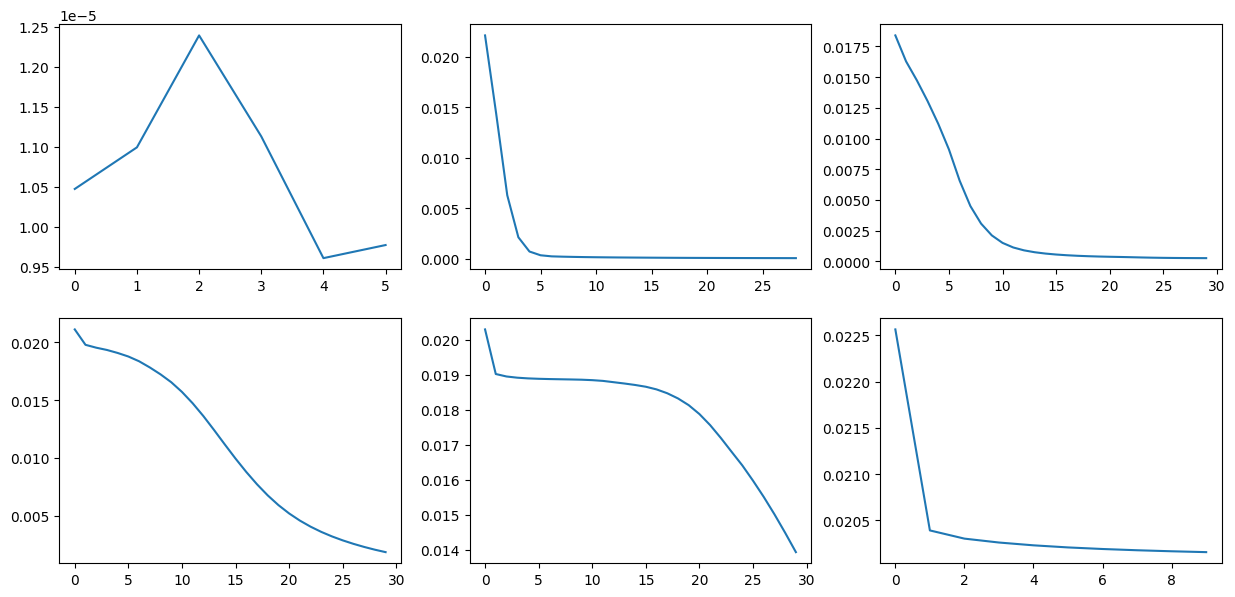

In [48]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
ax[0,0].plot(losses[0])
ax[0,1].plot(losses[1])
ax[0,2].plot(losses[2])
ax[1,0].plot(losses[3])
ax[1,1].plot(losses[4])
ax[1,2].plot(losses[5])




In [49]:
TEST_PREDS = [models[i](X_TEST[i]).detach() for i in range(len(models))]

In [50]:
r2_losses = [r2_score(TEST_PREDS[i].detach(), Y_TEST[i].detach()) for i in range(len(TEST_PREDS))]

In [51]:
r2_losses

[0.9995779658837645,
 0.9970475172145841,
 0.9717717130890356,
 0.6639876200591424,
 -2.2009278952464366,
 -3341.916075220918]

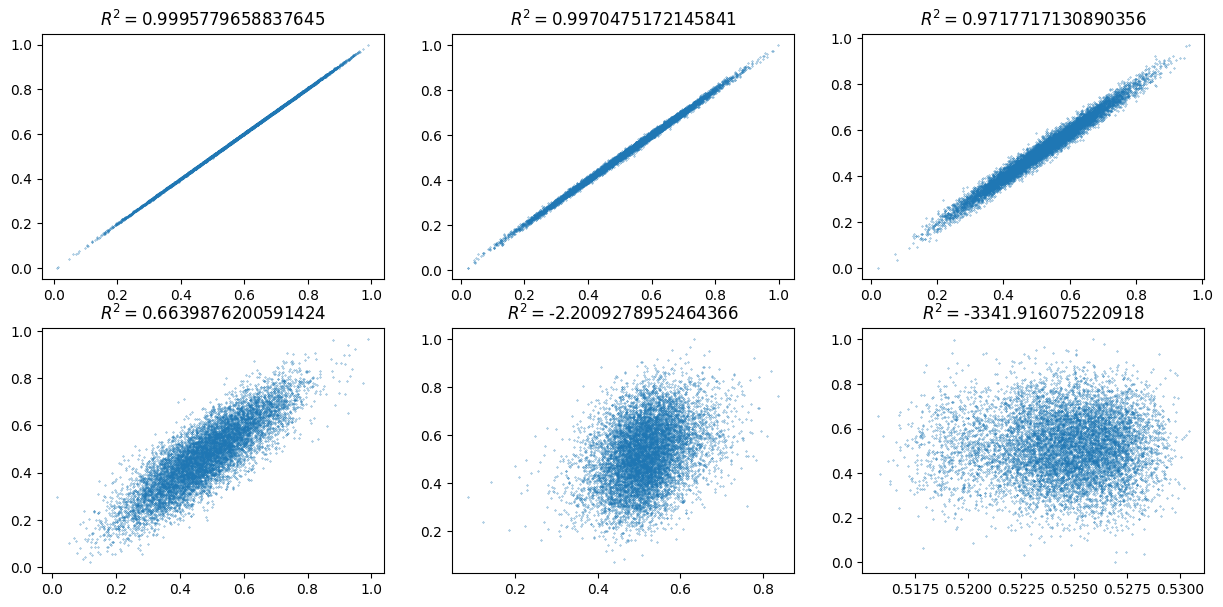

In [53]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
ax[0,0].scatter(TEST_PREDS[0], Y_TEST[0],marker='.', s=.3)
ax[0,1].scatter(TEST_PREDS[1], Y_TEST[1],marker='.', s=.3)
ax[0,2].scatter(TEST_PREDS[2], Y_TEST[2],marker='.', s=.3)
ax[1,0].scatter(TEST_PREDS[3], Y_TEST[3],marker='.', s=.3)
ax[1,1].scatter(TEST_PREDS[4], Y_TEST[4],marker='.', s=.3)
ax[1,2].scatter(TEST_PREDS[5], Y_TEST[5],marker='.', s=.3)



for ind, i in enumerate(ax.flatten()):
    i.set_title("$R^2 = $" + str(r2_losses[ind]))
    


In [1]:
torch.cuda.is_available()

NameError: name 'torch' is not defined